In [1]:
import plumed
import numpy as np
import pandas as pd
import MDAnalysis as mda
import nglview
import vmd
import os
from psfgen import PsfGen
import subprocess
import gromacs
import panedr
from gromacs.setup import *

import matplotlib.pyplot as plt

import yaml

[dgx-master.technion.ac.il:3952300] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3952300] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246


In [2]:
with open('../params.yaml','r') as f:
    config = yaml.safe_load(f)

In [3]:
system = config['base'][os.uname().nodename]

In [4]:
base  = os.getcwd()

In [5]:
import sys
extra_path = '/rg/mendels_prj/zadoki/bpti/src'  # whatever it is
if extra_path not in sys.path:
    sys.path.append(extra_path)
    
from utils.utils import clean, run_omp_slurm, run_mpi_slurm

## Simulate the five starting positions for BPTI

## state a

In [6]:
# create pdb psf files

gen = PsfGen(output="/dev/null")  # Suppress output since there's too much
gen.read_topology('../data/raw/top_all27_prot_lipid_na.inp')
gen.alias_atom(resname='ILE' , top_atomname='CD', pdb_atomname='CD1')
gen.add_segment(segid="P",
                pdbfile="../data/raw/1187409s_pdb1.pdb",
                first='NTER',
                last='CTER'
                )
gen.read_coords(segid="P", filename="../data/raw/1187409s_pdb1.pdb")
gen.regenerate_resids()
# pach disulfide bridges

gen.patch(patchname="DISU", targets=[("P","5"), ("P","55")])
gen.patch(patchname="DISU", targets=[("P","14"), ("P","38")])
gen.patch(patchname="DISU", targets=[("P","30"), ("P","51")])
gen.regenerate_angles()
gen.regenerate_dihedrals()
gen.guess_coords()
# make folder
os.makedirs('../data/interim/state_A', exist_ok=True)
gen.write_pdb('../data/interim/state_A/5bpi_A.pdb')
gen.write_psf('../data/interim/state_A/5bpi_A.psf')

In [68]:
%%capture
# solvate and ionize 
os.chdir("../data/interim/state_A")
# original topology ff 
f1 = topology(protein='protein_solvate', struct='5bpi_A.pdb',  ff='charmm27', water='tip4p', ignh=True, posrefc=50)
# solvate and ionize
f2 = solvate(boxtype='cubic',distance=1.0, **f1)
# minimize flexible
f3 = energy_minimize(integrator='cg',define = '-DFLEXIBLE',maxwarn=10, **f2)
# minimize rigid
f3 = energy_minimize(integrator='steep',maxwarn=10, **f3)
# restrained md npt 20ns
MD_restrained(r='/rg/mendels_prj/zadoki/bpti/data/interim/state_A/em/em.pdb', maxwarn=10, nstxout=1000, nstvout=0, nstenergy=100, nstxtcout = 0, nsteps= 10000000, **f3)

FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/state_A'

In [8]:
os.getcwd()

'/rg/mendels_prj/zadoki/bpti/notebooks'

In [16]:
run_mpi_slurm('mpirun -np 10 gmx mdrun  -v -deffnm md -cpi', **system)

slurmstepd: error: Unable to create TMPDIR [/usr/tmp]: Permission denied
slurmstepd: error: Setting TMPDIR to /tmp


CompletedProcess(args='srun -N1 -G1 --mpi=pmix singularity run --nv  --cleanenv --home $(pwd) --env OMP_NUM_THREADS=1 ~/gromacs_2023-2.sif', returncode=0)

In [16]:
data = panedr.edr_to_df('../data/interim/state_A/MD_POSRES/md.edr')

<Axes: xlabel='Time'>

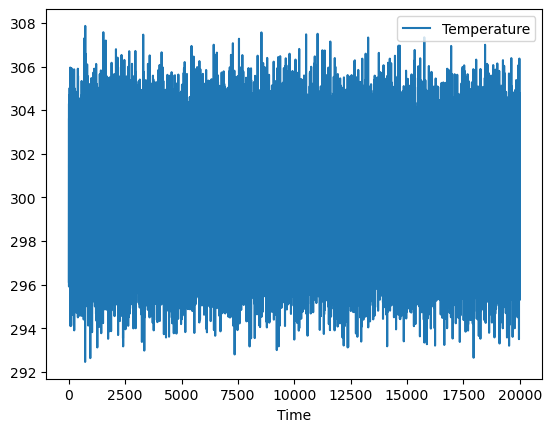

In [49]:

data.iloc[10:,:].plot(x='Time', y='Temperature')




<Axes: xlabel='Time'>

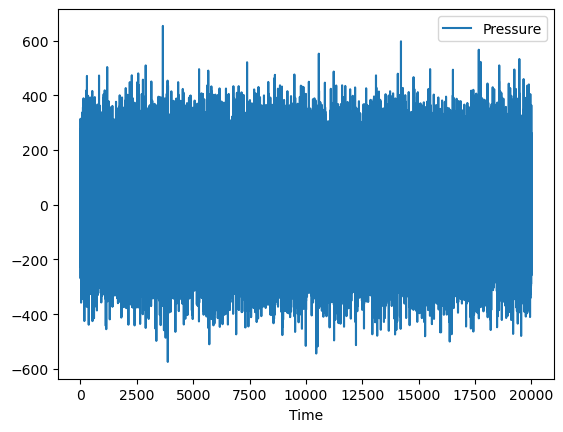

In [48]:
data.iloc[10:,:].plot(x='Time', y='Pressure')


<Axes: xlabel='Time'>

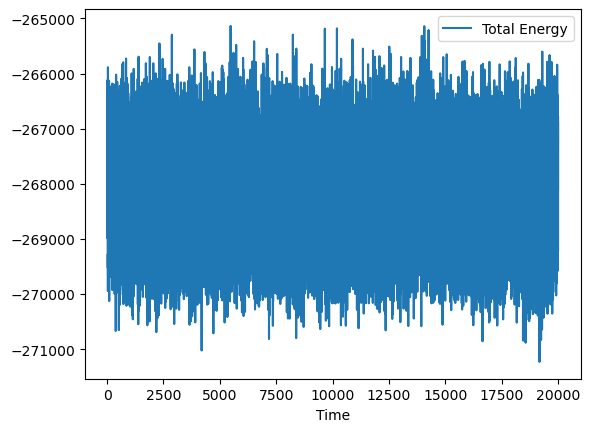

In [47]:
data.iloc[10:,:].plot(x='Time', y='Total Energy')


<Axes: xlabel='Time'>

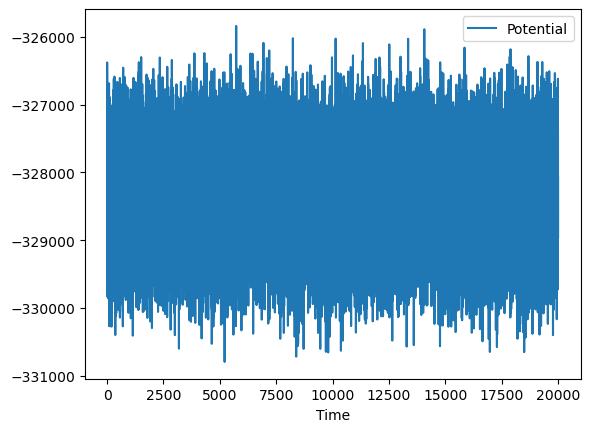

In [24]:
data.iloc[10:,:].plot(x='Time', y='Potential')


In [22]:
data.columns

Index(['Time', 'Bond', 'U-B', 'Proper Dih.', 'Improper Dih.', 'CMAP Dih.',
       'LJ-14', 'Coulomb-14', 'LJ (SR)', 'Disper. corr.', 'Coulomb (SR)',
       'Coul. recip.', 'Position Rest.', 'Potential', 'Kinetic En.',
       'Total Energy', 'Conserved En.', 'Temperature', 'Pres. DC', 'Pressure',
       'Constr. rmsd', 'Box-X', 'Box-Y', 'Box-Z', 'Volume', 'Density', 'pV',
       'Enthalpy', 'Vir-XX', 'Vir-XY', 'Vir-XZ', 'Vir-YX', 'Vir-YY', 'Vir-YZ',
       'Vir-ZX', 'Vir-ZY', 'Vir-ZZ', 'Pres-XX', 'Pres-XY', 'Pres-XZ',
       'Pres-YX', 'Pres-YY', 'Pres-YZ', 'Pres-ZX', 'Pres-ZY', 'Pres-ZZ',
       '#Surf*SurfTen', 'T-System', 'Lamb-System'],
      dtype='object')

In [61]:
# bootstrapping averages for convergence
dd = data["Potential"].to_numpy()
length = dd.shape[0]
num_points = 1000
num_straps = 10000
bootstraps = np.zeros(num_straps)

for i in range(num_straps) : 
    av = 0
    av2 = 0 
    for j in range(num_points) : av = av + dd[np.random.randint(0,length)]
    
    bootstraps[i] = (av / num_points)
 


In [62]:
bootstraps.mean(), bootstraps.var()

(-328378.99069004686, 365.82069318676866)

## state_b

In [69]:
os.chdir(base)

In [65]:
# create pdb psf files

gen = PsfGen(output="/dev/null")  # Suppress output since there's too much
gen.read_topology('../data/raw/top_all27_prot_lipid_na.inp')
gen.alias_atom(resname='ILE' , top_atomname='CD', pdb_atomname='CD1')
gen.add_segment(segid="P",
                pdbfile="../data/raw/1187409s_pdb2.pdb",
                first='NTER',
                last='CTER'
                )
gen.read_coords(segid="P", filename="../data/raw/1187409s_pdb2.pdb")
gen.regenerate_resids()
# pach disulfide bridges

gen.patch(patchname="DISU", targets=[("P","5"), ("P","55")])
gen.patch(patchname="DISU", targets=[("P","14"), ("P","38")])
gen.patch(patchname="DISU", targets=[("P","30"), ("P","51")])
gen.regenerate_angles()
gen.regenerate_dihedrals()
gen.guess_coords()
# make folder
os.makedirs('../data/interim/state_B', exist_ok=True)
gen.write_pdb('../data/interim/state_B/5bpi_B.pdb')
gen.write_psf('../data/interim/state_B/5bpi_B.psf')

In [70]:
%%capture
# solvate and ionize 
os.chdir("../data/interim/state_B")
# original topology ff 
f1 = topology(protein='protein_solvate', struct='5bpi_B.pdb',  ff='charmm27', water='tip4p', ignh=True, posrefc=50)
# solvate and ionize
f2 = solvate(boxtype='cubic',distance=1.0, **f1)
# minimize flexible
f3 = energy_minimize(integrator='cg',define = '-DFLEXIBLE',maxwarn=10, **f2)
# minimize rigid
f3 = energy_minimize(integrator='steep',maxwarn=10, **f3)
# restrained md npt 20ns
MD_restrained(r='/rg/mendels_prj/zadoki/bpti/data/interim/state_B/em/em.pdb', maxwarn=10, nstxout=1000, nstvout=0, nstenergy=100, nstxtcout = 0, nsteps= 10000000, **f3)

               :-) GROMACS - gmx pdb2gmx, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders


Using the Charmm27 force field in directory charmm27.ff

going to rename charmm27.ff/aminoacids.r2b
going to rename charmm27.ff/rna.r2b
Reading /rg/mendels_prj/zadoki/bpti/data/interim/state_B/5bpi_B.pdb...
Read '', 454 atoms
Analyzing pdb file
Splitting chemical chains based on TER records or chain id changing.
There are 1 chains and 0 blocks of water and 58 residues with 454 atoms

  chain  #res #atoms
  1 'A'    58    454  

Reading residue database... (Charmm27)
Processing chain 1 'A' (454 atoms, 58 residues)
Identified residue ARG1 as a starting terminus.
Identified residue ALA58 as a ending terminus.
Start terminus ARG-1: NH3+
End terminus ALA-58: COO-
Checking for duplicate atoms....
Generating any missing hydrogen atoms and/or adding termini.
Now there are 58 residues with 892 atoms
		--------- PLEASE NOTE ------------
You have successfully generated a topology from: /rg/mendels_prj/zadoki/bpti/data/interim/state_B/5bpi_B.pdb.
The Charmm27 force field and the tip4p water model

              :-) GROMACS - gmx editconf, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders

Note that major changes are planned in future for editconf, to improve usability and utility.
Read 892 atoms
No velocities found
    system size :  2.791  3.751  2.703 (nm)
    diameter    :  3.946               (nm)
    center      :  0.016 -0.006 -0.007 (nm)
    box vectors :  0.000  0.000  0.000 (nm)
    box angles  :   0.00   0.00   0.00 (degrees)
    box volume  :   0.00               (nm^3)
    shift       :  2.957  2.979  2.980 (nm)
new center      :  2.973  2.973  2.973 (nm)
new box vectors :  5.946  5.946  5.946 (nm)
new box angles  :  90.00  90.00  90.00 (degrees)
new box volume  : 210.21               (nm^3)


               :-) GROMACS - gmx solvate, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders


         based on residue and atom names, since they could not be
         definitively assigned from the information in your input
         files. These guessed numbers might deviate from the mass
         and radius of the atom type. Please check the output
         files if necessary.

NOTE: From version 5.0 gmx solvate uses the Van der Waals radii
from the source below. This means the results may be different
compared to previous GROMACS versions.

++++ PLEASE READ AND CITE THE FOLLOWING REFERENCE ++++
A. Bondi
van der Waals Volumes and Radii
J. Phys. Chem. 68 (1964) pp. 441-451
-------- -------- --- Thank You --- -------- --------



Volume                 :     210.205 (nm^3)
Density                :     1017.97 (g/l)
Number of solvent molecules:   6767   

Processing topology

Back Off! I just backed up /rg/mendels_prj/zadoki/bpti/data/interim/state_B/top/system.top to /rg/mendels_prj/zadoki/bpti/data/interim/state_B/top/#system.top.4#

GROMACS reminds you: "Everything Must Go" (Red Hot Chili Peppers)

[dgx-master.technion.ac.il:3743341] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3743341] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246


Adding line for 6767 solvent molecules with resname (SOL) to topology file (/rg/mendels_prj/zadoki/bpti/data/interim/state_B/top/system.top)


               :-) GROMACS - gmx genion, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

Will try to add 0 NA ions and 6 CL ions.
Select a continuous group of solvent molecules
Selected 13: 'SOL'

Processing topology
Replacing 6 solute molecules in topology file (/rg/mendels_prj/zadoki/bpti/data/interim/state_B/top/system.top)  by 0 NA and 6 CL ions.


              :-) GROMACS - gmx make_ndx, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders

Note that major changes are planned in future for trjconv, to improve usability and utility.
Select group for centering
Selected 18: '__main__'
Select group for output
Selected 0: 'System'


               :-) GROMACS - gmx grompp, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shvetsov  
   Alfons Sijbers     Peter Tieleman      Jon Vincent      Teemu Virolainen 
 Christian Wennberg    Maarten Wolf      Artem Zhmurov   
                           and the project leaders:

Analysing residue names:
There are:    58    Protein residues
There are:  6761      Water residues
There are:     6        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 52x52x52, spacing 0.114 0.114 0.114
This run will generate roughly 2 Mb of data


[dgx-master.technion.ac.il:3744318] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3744318] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246
                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shv

Analysing residue names:
There are:    58    Protein residues
There are:  6761      Water residues
There are:     6        Ion residues
Analysing Protein...
Analysing residues not classified as Protein/DNA/RNA/Water and splitting into groups...
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 52x52x52, spacing 0.114 0.114 0.114
This run will generate roughly 2 Mb of data


[dgx-master.technion.ac.il:3745253] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3745253] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246
                :-) GROMACS - gmx mdrun, 2020.6-plumed-2.8.0 (-:

                            GROMACS is written by:
     Emile Apol      Rossen Apostolov      Paul Bauer     Herman J.C. Berendsen
    Par Bjelkmar      Christian Blau   Viacheslav Bolnykh     Kevin Boyd    
 Aldert van Buuren   Rudi van Drunen     Anton Feenstra       Alan Gray     
  Gerrit Groenhof     Anca Hamuraru    Vincent Hindriksen  M. Eric Irrgang  
  Aleksei Iupinov   Christoph Junghans     Joe Jordan     Dimitrios Karkoulis
    Peter Kasson        Jiri Kraus      Carsten Kutzner      Per Larsson    
  Justin A. Lemkul    Viveca Lindahl    Magnus Lundborg     Erik Marklund   
    Pascal Merz     Pieter Meulenhoff    Teemu Murtola       Szilard Pall   
    Sander Pronk      Roland Schulz      Michael Shirts    Alexey Shv

turning H bonds into constraints...
turning H bonds into constraints...
turning H bonds into constraints...
Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K
Calculated rlist for 1x1 atom pair-list as 1.010 nm, buffer size 0.010 nm
Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm
Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 52x52x52, spacing 0.114 0.114 0.114



GROMACS reminds you: "All sorts of things can happen when you're open to new ideas and playing around with things." (Stephanie Kwolek, inventor of Kevlar)

[dgx-master.technion.ac.il:3745825] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3745825] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 237
[dgx-master.technion.ac.il:3745825] PMIX ERROR: NO-PERMISSIONS in file dstore_base.c at line 246


In [71]:
os.chdir('../state_B/MD_POSRES/')

In [ ]:
!srun -p mig -N1 -G1 --mpi=pmix singularity run --nv --cleanenv --home $(pwd) --env OMP_NUM_THREADS=4 ~/gromacs_2023-2.sif  mpirun -np 1 gmx mdrun -v -deffnm md  -ntomp 4  -pin off  

slurmstepd: error: Unable to create TMPDIR [/usr/tmp]: Permission denied
slurmstepd: error: Setting TMPDIR to /tmp
               :-) GROMACS - gmx mdrun, 2021-plumed-2.9.0-dev (-:

                            GROMACS is written by:
     Andrey Alekseenko              Emile Apol              Rossen Apostolov     
         Paul Bauer           Herman J.C. Berendsen           Par Bjelkmar       
       Christian Blau           Viacheslav Bolnykh             Kevin Boyd        
     Aldert van Buuren           Rudi van Drunen             Anton Feenstra      
    Gilles Gouaillardet             Alan Gray               Gerrit Groenhof      
       Anca Hamuraru            Vincent Hindriksen          M. Eric Irrgang      
      Aleksei Iupinov           Christoph Junghans             Joe Jordan        
    Dimitrios Karkoulis            Peter Kasson                Jiri Kraus        
      Carsten Kutzner              Per Larsson              Justin A. Lemkul     
       Viveca Lindahl        

## visualize with nglview

In [7]:
os.chdir(base)
os.chdir('../data/interim/state_B/MD_POSRES/')

In [30]:
u = mda.Universe('md.gro', 'md.trr')

In [31]:
u.trajectory.n_frames

10001

In [45]:
u.universe.residues[1000]

<Residue SOL, 1001>

In [50]:
prot = u.select_atoms("(protein and not type H) or (resname SOL witgin  )")

In [33]:
prot

<AtomGroup with 454 atoms>

In [34]:
view = nglview.show_mdanalysis(prot)
view

NGLWidget(max_frame=10000)

In [17]:
view.add_trajectory(u)

In [24]:
u.trajectory

<GROReader md.gro with 1 frames of 27942 atoms>